In [142]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib

In [196]:
import warnings
warnings.filterwarnings('ignore')

In [143]:
data_folder = pathlib.Path('../../../birds')
PIXEL_SIZE = 224

Extract train test and validation datasets from Bird Species dataset

In [144]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(PIXEL_SIZE, PIXEL_SIZE),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "valid",
    image_size=(PIXEL_SIZE, PIXEL_SIZE),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(PIXEL_SIZE, PIXEL_SIZE),
    batch_size=32)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [145]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32,)


In [146]:
y = np.concatenate([y for x, y in train_dataset], axis=0)

In [69]:
y

array([ 18,  21, 240, ...,  85, 234, 449], dtype=int64)

In [72]:
import pandas as pd

labels = pd.Series(y)
val_counts = labels.value_counts()
sorted_counts = val_counts.sort_values(ascending=False)
print(sorted_counts)

434    263
291    248
184    233
374    233
41     220
      ... 
382    130
215    130
416    130
25     130
453    130
Name: count, Length: 525, dtype: int64


In [71]:
top3_classes = sorted_counts[:3]

In [73]:
top3_list = top3_classes.index.to_list()
top3_list

[434, 291, 184]

In [128]:
clazz_names = train_dataset.class_names

In [132]:
selected_classes = [clazz_names[i] for i in top3_list]
selected_classes

['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']

After defining top 3 most frequent classes, I selected train, validation and test samples of these species manually and put them in separate folders. Then read data from these files:

In [ ]:
train_dataset = image_dataset_from_directory(
    data_folder / "train_3",
    image_size=(PIXEL_SIZE, PIXEL_SIZE),
    label_mode = 'categorical',
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "valid_3",
    image_size=(PIXEL_SIZE, PIXEL_SIZE),
    label_mode = 'categorical',
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test_3",
    image_size=(PIXEL_SIZE, PIXEL_SIZE),
    label_mode = 'categorical',
    batch_size=32)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


In [352]:
reduced_class_list = train_dataset.class_names
reduced_class_list

['D-ARNAUDS BARBET', 'HOUSE FINCH', 'RUFOUS TREPE']

In [158]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    print(labels_batch)
    break

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 3)
tf.Tensor(
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]], shape=(32, 3), dtype=float32)


Get base vgg model for transfer learning.

In [166]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(PIXEL_SIZE, PIXEL_SIZE, 3))

Freeze all layers except last 4 layer.

In [167]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [168]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Add a data augmentation stage and a classifier to the convolutional base. Define a new dense neural networks, apply data augmentation, and use softmax for multiclass classification

In [172]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x) # change dropout to 0.2
outputs = layers.Dense(3, activation="softmax")(x)
model_1 = keras.Model(inputs, outputs)

In [173]:
model_1.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_11  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_11 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_10 (Flatten)        (None, 25088)             0  

In [174]:
model_1.compile(loss="categorical_crossentropy",
              optimizer="nadam", # change optimizer to nadam
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history_1 = model_1.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


24/24 [==============================] - 32s 1s/step - loss: 1.0989 - accuracy: 0.2970 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 2/30
24/24 [==============================] - 37s 2s/step - loss: 1.0983 - accuracy: 0.3535 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 3/30
24/24 [==============================] - 38s 2s/step - loss: 1.0980 - accuracy: 0.3535 - val_loss: 1.0992 - val_accuracy: 0.3333
Epoch 4/30
24/24 [==============================] - 38s 2s/step - loss: 1.0978 - accuracy: 0.3535 - val_loss: 1.0998 - val_accuracy: 0.3333
Epoch 5/30
24/24 [==============================] - 37s 2s/step - loss: 1.0982 - accuracy: 0.3535 - val_loss: 1.0999 - val_accuracy: 0.3333
Epoch 6/30
24/24 [==============================] - 38s 2s/step - loss: 1.0981 - accuracy: 0.3535 - val_loss: 1.0991 - val_accuracy: 0.3333
Epoch 7/30
24/24 [==============================] - 37s 2s/step - loss: 1.0980 - accuracy: 0.3535 - val_loss: 1.0993 - val_accuracy: 0.3333
Epoch 8/30
24/24 [=============

In [175]:
import matplotlib.pyplot as plt

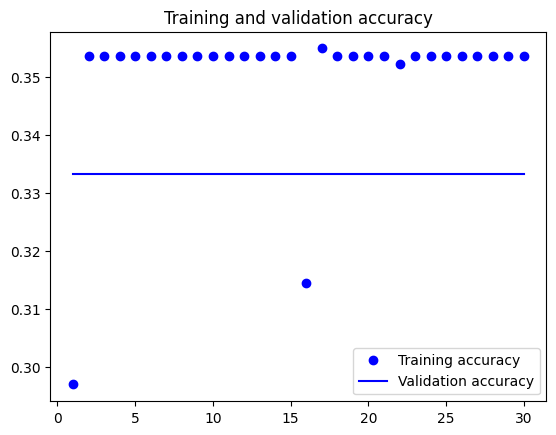

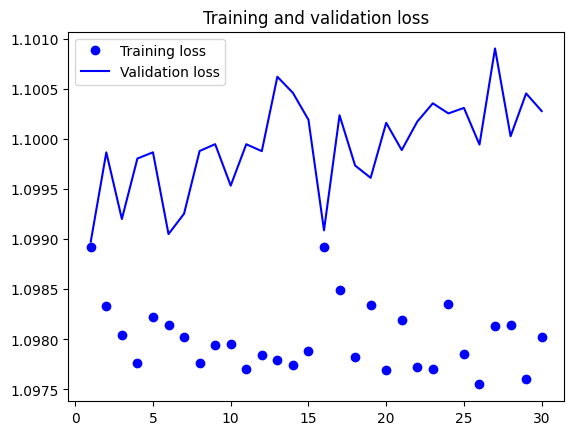

In [176]:
acc = history_1.history["accuracy"]
val_acc = history_1.history["val_accuracy"]
loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the test set


In [358]:
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 1s 642ms/step - loss: 1.0990 - accuracy: 0.3333
Test accuracy: 0.333


In [359]:
y_true_one_hot = test_dataset.map(lambda x, y: y)
y_true_one_hot = np.concatenate(list(y_true_one_hot.as_numpy_iterator()))
y_true_classes = np.argmax(y_true_one_hot, axis=1)

y_pred_probs = test_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

1/1 [==============================] - 1s 594ms/step


In [360]:
y_true_classes

array([2, 1, 2, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 2, 0], dtype=int64)

In [361]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)
report = classification_report(y_true_classes, y_pred_classes, target_names=reduced_class_list)
print(report)

[[0 0 5]
 [0 0 5]
 [0 0 5]]
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.00      0.00      0.00         5
     HOUSE FINCH       0.00      0.00      0.00         5
    RUFOUS TREPE       0.33      1.00      0.50         5

        accuracy                           0.33        15
       macro avg       0.11      0.33      0.17        15
    weighted avg       0.11      0.33      0.17        15



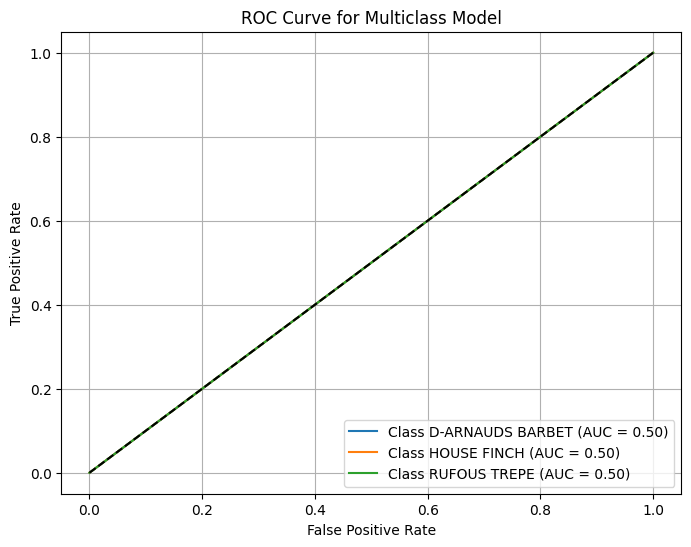

In [364]:
n_classes = y_true_one_hot.shape[1]
auc_scores = []
for i in range(n_classes):
    auc_score = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
    auc_scores.append(auc_score)

# Plot the AUC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(reduced_class_list[i], auc_scores[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Draw image of a species that misclassified 

In [ ]:

import matplotlib.pyplot as plt



In [356]:
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

In [376]:
misclassified_indices


array([ 1,  3,  4,  5,  7,  8, 10, 11, 12, 14], dtype=int64)

In [451]:
image_list = test_dataset.map(lambda x, y: x)
all_images_flat = np.concatenate(list(image_list.as_numpy_iterator()))

(-0.5, 223.5, 223.5, -0.5)

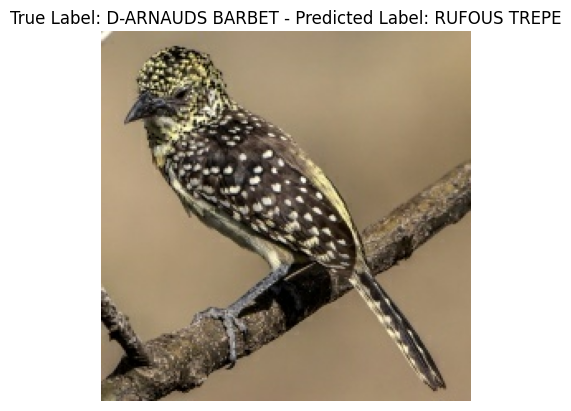

In [473]:
miss_index = misclassified_indices[1]
true_label = reduced_class_list[y_true_classes[miss_index]]
pred_label = reduced_class_list[y_pred_classes[miss_index]]
plt.imshow(all_images_flat[miss_index].astype("uint8"))
plt.title(f"True Label: {true_label} - Predicted Label: {pred_label}")
plt.axis("off")

(-0.5, 223.5, 223.5, -0.5)

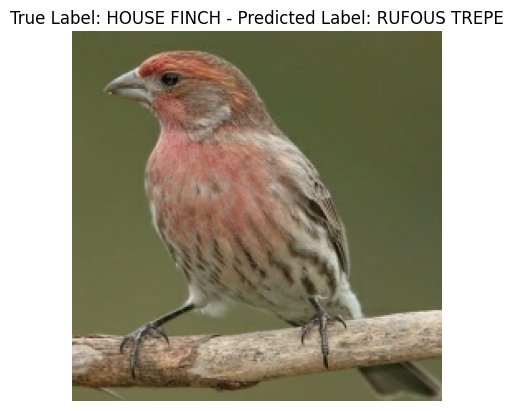

In [474]:
miss_index = misclassified_indices[0]
true_label = reduced_class_list[y_true_classes[miss_index]]
pred_label = reduced_class_list[y_pred_classes[miss_index]]
plt.imshow(all_images_flat[miss_index].astype("uint8"))
plt.title(f"True Label: {true_label} - Predicted Label: {pred_label}")
plt.axis("off")

The results show that model couldn't fit with high accuracy, probably because of the smallness of the train and validation dataset. Moreover, number of RUFOUS TREPE bird images greater than others. That's why model tends to classify most of the images with RUFOUS TREPE.

# 2nd Try

Try by freezing all VGG16 model and not include top layer. Do feature extraction

In [311]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(PIXEL_SIZE, PIXEL_SIZE, 3))

In [312]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [314]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [315]:
model.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_all_freezed.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30


24/24 [==============================] - 25s 1s/step - loss: 14.9396 - accuracy: 0.9073 - val_loss: 42.3842 - val_accuracy: 0.7333
Epoch 2/30
24/24 [==============================] - 28s 1s/step - loss: 3.3531 - accuracy: 0.9798 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/30
24/24 [==============================] - 29s 1s/step - loss: 2.4312 - accuracy: 0.9839 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/30
24/24 [==============================] - 29s 1s/step - loss: 0.0897 - accuracy: 0.9960 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/30
24/24 [==============================] - 29s 1s/step - loss: 3.3009 - accuracy: 0.9825 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/30
24/24 [==============================] - 29s 1s/step - loss: 1.0310 - accuracy: 0.9933 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/30
24/24 [==============================] - 29s 1s/step - loss: 2.2696 - accuracy: 0.9933 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch

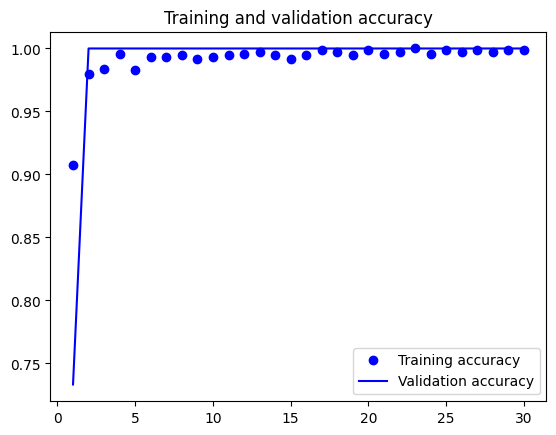

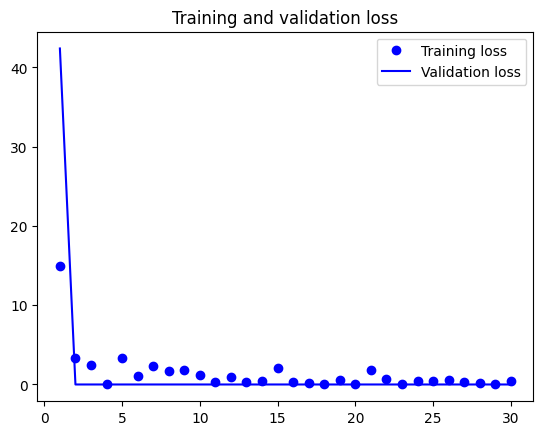

In [316]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Data overfits in this model.

In [324]:

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 1s 546ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test accuracy: 1.000


In [327]:
y_true_one_hot = test_dataset.map(lambda x, y: y)
y_true_one_hot = np.concatenate(list(y_true_one_hot.as_numpy_iterator()))
y_true_classes = np.argmax(y_true_one_hot, axis=1)

y_pred_probs = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

1/1 [==============================] - 1s 606ms/step


In [353]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)
report = classification_report(y_true_classes, y_pred_classes, target_names=reduced_class_list)
print(report)

[[2 2 1]
 [1 1 3]
 [2 2 1]]
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.40      0.40      0.40         5
     HOUSE FINCH       0.20      0.20      0.20         5
    RUFOUS TREPE       0.20      0.20      0.20         5

        accuracy                           0.27        15
       macro avg       0.27      0.27      0.27        15
    weighted avg       0.27      0.27      0.27        15



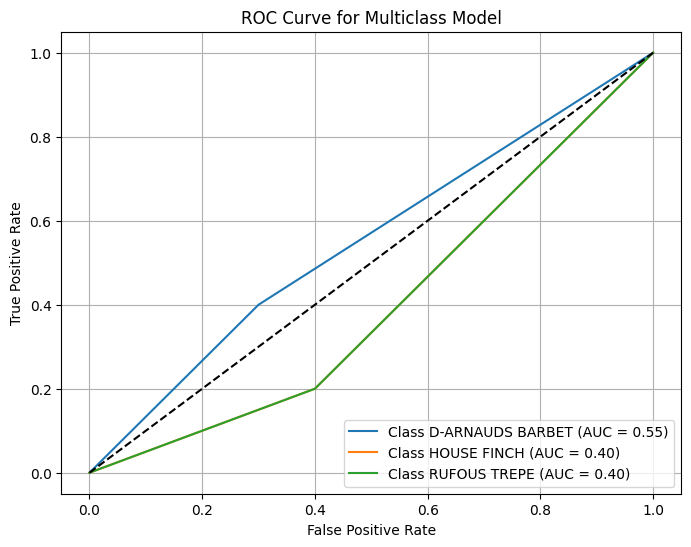

In [355]:
n_classes = y_true_one_hot.shape[1]
auc_scores = []
for i in range(n_classes):
    auc_score = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
    auc_scores.append(auc_score)

# Plot the AUC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(reduced_class_list[i], auc_scores[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 3rd try

In [343]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(PIXEL_SIZE, PIXEL_SIZE, 3))

# Freeze all years except last two
conv_base.trainable = True
for layer in conv_base.layers[:-2]:
    layer.trainable = False

In [344]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.2, 0.3)
    ]
)

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = keras.layers.GlobalAveragePooling2D()(x) # change some layers here
x = keras.layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_3 = keras.Model(inputs, outputs)

Decrease learning rate for better optimization and avoid sudden overfit

In [345]:
opt = keras.optimizers.Nadam(learning_rate=1e-5)
model_3.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history_3 = model_3.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
24/24 [==============================] - 26s 1s/step - loss: 3.3324 - accuracy: 0.4274 - val_loss: 2.8060 - val_accuracy: 0.4000
Epoch 2/30
24/24 [==============================] - 25s 1s/step - loss: 1.5238 - accuracy: 0.6613 - val_loss: 0.9592 - val_accuracy: 0.8000
Epoch 3/30
24/24 [==============================] - 29s 1s/step - loss: 0.8443 - accuracy: 0.7796 - val_loss: 0.7098 - val_accuracy: 0.8667
Epoch 4/30
24/24 [==============================] - 30s 1s/step - loss: 0.6801 - accuracy: 0.8374 - val_loss: 0.3928 - val_accuracy: 0.9333
Epoch 5/30
24/24 [==============================] - 31s 1s/step - loss: 0.4764 - accuracy: 0.8952 - val_loss: 0.4393 - val_accuracy: 0.9333
Epoch 6/30
24/24 [==============================] - 31s 1s/step - loss: 0.4078 - accuracy: 0.9019 - val_loss: 0.3491 - val_accuracy: 0.9333
Epoch 7/30
24/24 [==============================] - 32s 1s/step - loss: 0.3226 - accuracy: 0.9220 - val_loss: 0.2180 - val_accuracy: 0.9333
Epoch 8/30
24/24 [==

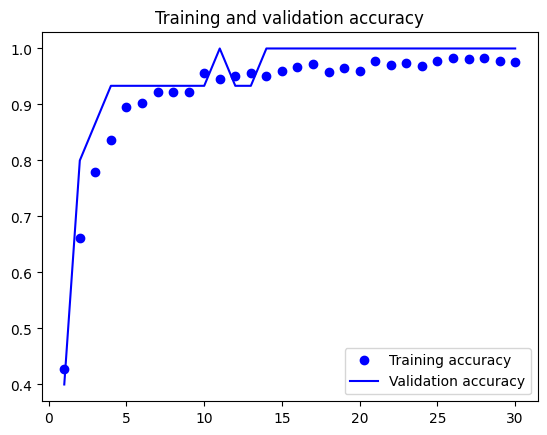

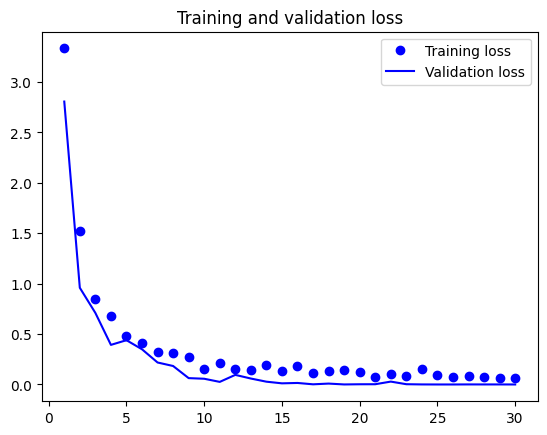

In [430]:
acc = history_3.history["accuracy"]
val_acc = history_3.history["val_accuracy"]
loss = history_3.history["loss"]
val_loss = history_3.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [445]:
test_model = keras.models.load_model(
    "./models/feature_extraction_3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 1s 710ms/step - loss: 1.1793e-05 - accuracy: 1.0000
Test accuracy: 1.000


In [446]:
y_true_one_hot = test_dataset.map(lambda x, y: y)
y_true_one_hot = np.concatenate(list(y_true_one_hot.as_numpy_iterator()))
y_true_classes = np.argmax(y_true_one_hot, axis=1)

y_pred_probs = test_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

1/1 [==============================] - 1s 649ms/step


In [447]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)
report = classification_report(y_true_classes, y_pred_classes, target_names=reduced_class_list)
print(report)

[[1 1 3]
 [2 2 1]
 [2 2 1]]
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.20      0.20      0.20         5
     HOUSE FINCH       0.40      0.40      0.40         5
    RUFOUS TREPE       0.20      0.20      0.20         5

        accuracy                           0.27        15
       macro avg       0.27      0.27      0.27        15
    weighted avg       0.27      0.27      0.27        15



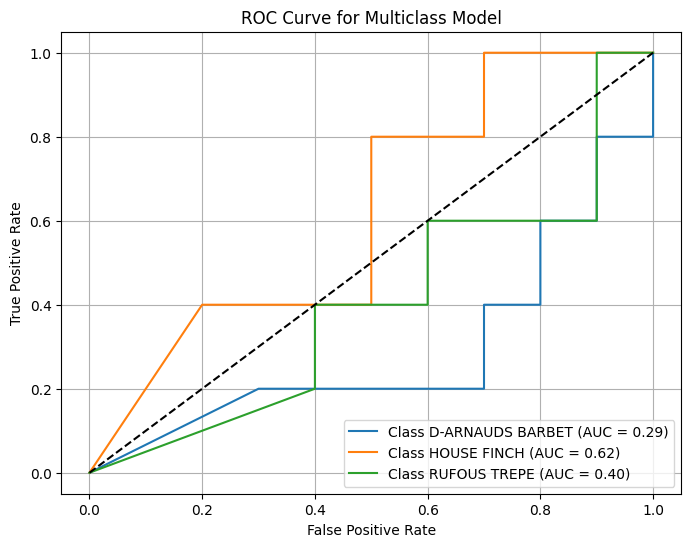

In [448]:
n_classes = y_true_one_hot.shape[1]
auc_scores = []
for i in range(n_classes):
    auc_score = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
    auc_scores.append(auc_score)

# Plot the AUC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(reduced_class_list[i], auc_scores[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()